In [1]:
# Importing necessary libraly

import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os

import numpy as np
from matplotlib import pyplot as plt
import keras 
import pandas as pd
from datetime import datetime 

from keras.utils import normalize
#from keras.metrics import MeanIoU

Segmentation Models: using `tf.keras` framework.


In [2]:
#Resizing images, if needed
SIZE_X = 512
SIZE_Y = 512
n_classes= 4 #Number of classes for segmentation

In [3]:
#Capture training image info as a list
train_images = []

for directory_path in glob.glob("../Tiles/Tiles/South/images/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 1)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

print("this is number of train images in array", len(train_images))

this is number of train images in array 456


In [4]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("../Tiles/Tiles/South/masks/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

print("this is number of train masks in array", len(train_masks))

this is number of train masks in array 456


In [5]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

#train_images = np.expand_dims(train_images, axis=3)
#train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

print("Shape of train_images:", train_images.shape)
print("Shape of train_masks_input:", train_masks_input.shape)

C:\Users\gaowutong\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Shape of train_images: (456, 512, 512, 3)
Shape of train_masks_input: (456, 512, 512, 1)


In [6]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

Class values in the dataset are ...  [0 1 2 3]


In [9]:
from sklearn.model_selection import train_test_split
import numpy as np

# Initial split: 10% for testing, 90% for training
X_train_full, X_test, y_train_full, y_test = train_test_split(train_images, train_masks_input, test_size=0.10, random_state=0)

# Further split the training data: 80% for training, 10% for further testing
X_train, X_further_test, y_train, y_further_test = train_test_split(X_train_full, y_train_full, test_size=0.111, random_state=0)

print("Class values in the training dataset are:", np.unique(y_train))  # 0 is the background/few unlabeled
print("Class values in the further testing dataset are:", np.unique(y_further_test))


Class values in the training dataset are: [0 1 2 3]
Class values in the further testing dataset are: [0 1 2 3]


In [10]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[1], n_classes))


test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[1], n_classes))

print(len(y_train))
print(len(y_test))

364
46


In [11]:
# n_classes=8
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (built-up: 1.; forest: 2.; water: 0.5; bare land: 0.5, background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
#dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.1111111111111111,0.1111111111111111,0.1111111111111111,0.1111111111111111,0.1111111111111111,0.1111111111111111,0.1111111111111111,0.1111111111111111,0.1111111111111111])) #class weights for 9 classes of our labels

focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


# Compile keras model with defined optimizer, loss, and metrics including accuracy
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), 'accuracy']

In [12]:
from tensorflow.keras import layers, models
import segmentation_models as sm

# Define the resolution preservation backbone
def resolution_preserving_backbone(input_shape):
    inputs = layers.Input(input_shape)
    #     ...................................................  code can be shared on REQUEST

# Define the VHF_Para_weak supervision model
def VHF_Paraweak_supervision_model(input_shape, num_classes):
    
#     ...................................................  code can be shared on REQUEST
    return model

# Define the total model
def VHF_Para(input_shape, num_classes):
    backbone = resolution_preserving_backbone(input_shape)
#     #     ...................................................  code can be shared on REQUEST

# Instantiate the total model
input_shape = (SIZE_X, SIZE_Y, 3)  # Assuming SIZE_X and SIZE_Y are defined
num_classes = 4  # Assuming 8 classes
segmentation_model, VHF_Para_weak_supervision_model = VHF_Para(input_shape, num_classes)

# Compile the models
optim = keras.optimizers.Adam(learning_rate=LR)
segmentation_model.compile(optimizer=optim, loss=total_loss, metrics=metrics)
VHF_Para_weak_supervision_model.compile(optimizer=optim, loss=total_loss, metrics=metrics)

# Print summary for segmentation model
print("Segmentation Model Summary:")
segmentation_model.summary()

# Print summary for weak supervision model
print("\nVHF_Para_Weak Supervision Model Summary:")
VHF_Para_weak_supervision_model.summary()

Segmentation Model Summary:
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 model_1 (Functional)        (None, 512, 512, 4)       24456589  
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 4)       20        
                                                                 
Total params: 24,456,609
Trainable params: 24,439,259
Non-trainable params: 17,350
_________________________________________________________________

Weak Supervision Model Summary:
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                              

In [14]:
pwd

'E:\\small_area\\NAIP\\Luisiana\\codes'

In [13]:
import pandas as pd
import time

# Train the models
start_time_segmentation = time.time()
history_segmentation = segmentation_model.fit(X_train, y_train_cat, 
                                              validation_data=(X_test, y_test_cat), 
                                              batch_size=8, 
                                              epochs=50)
end_time_segmentation = time.time()
training_time_segmentation = end_time_segmentation - start_time_segmentation

start_time_weak_supervision = time.time()
history_weak_supervision = weak_supervision_model.fit(X_train, y_train_cat, 
                                                      validation_data=(X_test, y_test_cat), 
                                                      batch_size=8, 
                                                      epochs=50)
end_time_weak_supervision = time.time()
training_time_weak_supervision = end_time_weak_supervision - start_time_weak_supervision

# Save the models
segmentation_model.save("../model_south/Segn/segmentation_model.keras")
weak_supervision_model.save("../model_south/C2FNet/weak_supervision_model.keras")

# After training, you can extract accuracy from the history object
final_accuracy = history_segmentation.history['accuracy'][-1]
print("Final Accuracy (Segmentation):", final_accuracy)

final_accuracy = history_weak_supervision.history['accuracy'][-1]
print("Final Accuracy (Weak Supervision):", final_accuracy)

# Convert history to DataFrame
history_segmentation_df = pd.DataFrame(history_segmentation.history)
history_segmentation_df['epoch'] = range(1, len(history_segmentation_df) + 1)
history_segmentation_df['training_time'] = training_time_segmentation

history_weak_supervision_df = pd.DataFrame(history_weak_supervision.history)
history_weak_supervision_df['epoch'] = range(1, len(history_weak_supervision_df) + 1)
history_weak_supervision_df['training_time'] = training_time_weak_supervision

# Save history to CSV files
history_segmentation_df.to_csv('../csv_south/history_segmentation.csv', index=False)
history_weak_supervision_df.to_csv('../csv_south/history_weak_supervision.csv', index=False)


Epoch 1/50
46/46 [==============================] - 271s 6s/step - loss: 0.8481 - iou_score: 0.0435 - f1-score: 0.0785 - accuracy: 0.2470 - val_loss: 0.8215 - val_iou_score: 0.0690 - val_f1-score: 0.1217 - val_accuracy: 0.3637
Epoch 2/50
46/46 [==============================] - 266s 6s/step - loss: 0.7554 - iou_score: 0.1970 - f1-score: 0.2867 - accuracy: 0.5705 - val_loss: 0.7780 - val_iou_score: 0.2135 - val_f1-score: 0.2942 - val_accuracy: 0.5713
Epoch 3/50
46/46 [==============================] - 265s 6s/step - loss: 0.6711 - iou_score: 0.3530 - f1-score: 0.4590 - accuracy: 0.6773 - val_loss: 0.7517 - val_iou_score: 0.2193 - val_f1-score: 0.3002 - val_accuracy: 0.6300
Epoch 4/50
46/46 [==============================] - 265s 6s/step - loss: 0.6020 - iou_score: 0.4154 - f1-score: 0.5212 - accuracy: 0.7517 - val_loss: 0.7136 - val_iou_score: 0.2775 - val_f1-score: 0.3773 - val_accuracy: 0.7037
Epoch 5/50
46/46 [==============================] - 265s 6s/step - loss: 0.5608 - iou_score:

In [17]:
# # Train the models
# history_segmentation = segmentation_model.fit(X_train, y_train_cat, 
#                                               validation_data=(X_test, y_test_cat), 
#                                               batch_size=8, 
#                                               epochs=50)

history_weak_supervision = weak_supervision_model.fit(X_train, y_train_cat, 
                                                      validation_data=(X_test, y_test_cat), 
                                                      batch_size=8, 
                                                      epochs=50)
# Save the models
# segmentation_model.save("Model/segmentation_model.h5")
weak_supervision_model.save("Model/weak_supervision_model.h5")


# After training, you can extract accuracy from the history object
final_accuracy = history_segmentation.history['accuracy'][-1]
print("Final Accuracy:", final_accuracy)

In [18]:
# After training, you can extract accuracy from the history object
final_accuracy = history_weak_supervision.history['accuracy'][-1]
print("Final Accuracy:", final_accuracy)

Final Accuracy: 0.9132119417190552


In [12]:
from tensorflow.keras.models import load_model

In [13]:
from tensorflow.keras.models import load_model
from segmentation_models.losses import CategoricalFocalLoss, DiceLoss

def categorical_focal_dice_loss(y_true, y_pred):
    return CategoricalFocalLoss()(y_true, y_pred) + DiceLoss()(y_true, y_pred)

# Now you can load the model
weak_supervision_model = load_model("../SmallV3/Model/weak_supervision_model.h5", compile=False, custom_objects={'categorical_focal_dice_loss': categorical_focal_dice_loss})


# General_confusion matricx

8/8 [==============================] - 27s 3s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94   1127650
           1       0.88      0.60      0.72   1789116
           2       0.66      0.67      0.67   2331188
           3       0.67      0.72      0.69   2864763
           4       0.69      0.74      0.72   2839143
           5       0.74      0.75      0.75   2466346
           6       0.81      0.85      0.83   2035134
           7       0.75      0.82      0.78    601444
           8       0.92      0.99      0.95      1536

    accuracy                           0.74  16056320
   macro avg       0.79      0.79      0.78  16056320
weighted avg       0.75      0.74      0.74  16056320

Confusion Matrix:
[[1059349   67258     373      68      14     251     246      91       0]
 [  72333 1079882  611479   18014    2838    2773    1782       5      10]
 [     75   73327 1563641  666928   22525    3830    

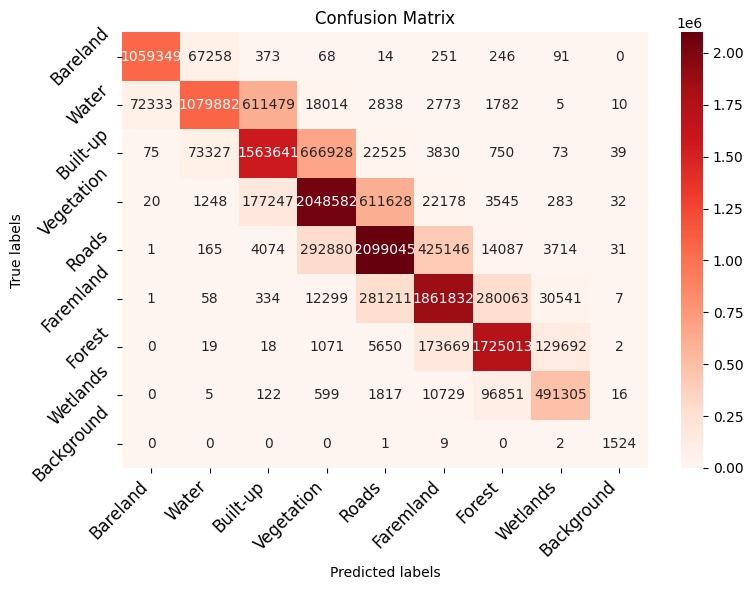

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define class names
class_names = ['Bareland', 'Water', 'Built-up', 'Vegetation', 'Roads', 'Faremland', 'Forest', 'Wetlands', 'Background']

# Assuming you have your model `weak_supervision_model` and test data `X_test` already defined and trained

# Predict on test data
y_pred = weak_supervision_model.predict(X_test)

# Convert predictions and ground truth masks back to label format
y_pred_labels = np.argmax(y_pred, axis=-1)
y_test_labels = np.argmax(y_test_cat, axis=-1)

# Flatten the labels for classification report and confusion matrix
y_pred_flat = y_pred_labels.flatten()
y_test_flat = y_test_labels.flatten()

# Calculate classification report
report = classification_report(y_test_flat, y_pred_flat)
print("Classification Report:")
print(report)

# Calculate confusion matrix
cm = confusion_matrix(y_test_flat, y_pred_flat)
print("Confusion Matrix:")
print(cm)

# Calculate overall accuracy
accuracy = accuracy_score(y_test_flat, y_pred_flat)
print("Overall Accuracy:", accuracy)

# Plot confusion matrix with class names, rotated labels, and increased font size
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)

# Rotate the x-axis and y-axis labels
heatmap.set_xticklabels(class_names, rotation=45, ha='right', fontsize=12)
heatmap.set_yticklabels(class_names, rotation=45, va='center', fontsize=12)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Save the plot as a TIFF image with 1000 DPI
plt.tight_layout()
plt.savefig('Model/c2f/metrics/confusion_matrix_class_names11.png', dpi=1000)

plt.show()

# accuracy of each classes 

In [18]:
import numpy as np
from sklearn.metrics import accuracy_score

# Assuming you have your model `model` and test data `X_test` already defined and trained

# Predict on test data
y_pred = weak_supervision_model.predict(X_test)

# Convert predictions and ground truth masks back to label format
y_pred_labels = np.argmax(y_pred, axis=-1)
y_test_labels = np.argmax(y_test_cat, axis=-1)

# Get unique labels
labels = np.unique(y_test_labels)

# Calculate accuracy for each class
for label in labels:
    # Filter predictions and ground truth for the current label
    y_pred_label = y_pred_labels[y_test_labels == label]
    y_true_label = y_test_labels[y_test_labels == label]
    
    # Calculate accuracy
    acc = accuracy_score(y_true_label, y_pred_label)
    
    # Print accuracy for the current class
    print(f'Accuracy - Class {label}: {acc}')

8/8 [==============================] - 27s 3s/step
Accuracy - Class 0: 0.9394306744113865
Accuracy - Class 1: 0.6035841164016196
Accuracy - Class 2: 0.670748562535497
Accuracy - Class 3: 0.7150965018746751
Accuracy - Class 4: 0.7393234507737018
Accuracy - Class 5: 0.7548948930928588
Accuracy - Class 6: 0.8476164223092927
Accuracy - Class 7: 0.8168757191026929
Accuracy - Class 8: 0.9921875


# Accuracy Graph for each class

8/8 [==============================] - 24s 3s/step


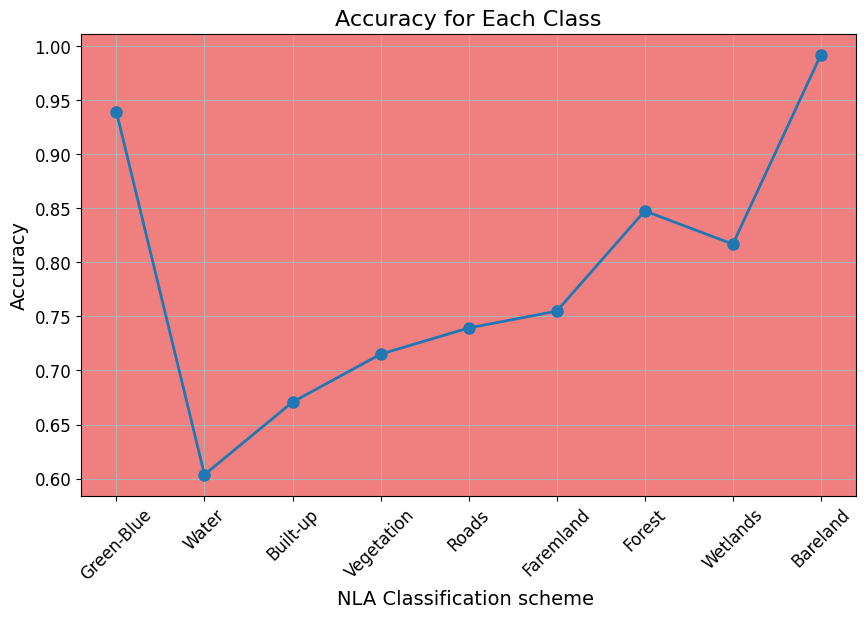

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Define class names
class_names = ['Green-Blue', 'Water', 'Built-up', 'Vegetation', 'Roads', 'Faremland', 'Forest', 'Wetlands', 'Bareland']

# Assuming you have your model `weak_supervision_model` and test data `X_test` already defined and trained

# Predict on test data
y_pred = weak_supervision_model.predict(X_test)

# Convert predictions and ground truth masks back to label format
y_pred_labels = np.argmax(y_pred, axis=-1)
y_test_labels = np.argmax(y_test_cat, axis=-1)

# Get unique labels
labels = np.unique(y_test_labels)

# Initialize a list to store accuracy values for each class
accuracies = []

# Calculate accuracy for each class
for label in labels:
    # Filter predictions and ground truth for the current label
    y_pred_label = y_pred_labels[y_test_labels == label]
    y_true_label = y_test_labels[y_test_labels == label]
    
    # Calculate accuracy
    acc = accuracy_score(y_true_label, y_pred_label)
    
    # Append accuracy to the list
    accuracies.append(acc)

# Plot line graph for accuracy with class names and customized style
plt.figure(figsize=(10, 6))
plt.plot(class_names, accuracies, marker='o', linestyle='-', linewidth=2, markersize=8)  # Increase line size and marker size
plt.title('Accuracy for Each Class', fontsize=16)  # Increase title font size
plt.xlabel('NLA Classification scheme ', fontsize=14)  # Increase x-axis label font size
plt.ylabel('Accuracy', fontsize=14)  # Increase y-axis label font size
plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels and increase font size
plt.yticks(fontsize=12)  # Increase y-axis tick font size
plt.grid(True)
plt.gca().set_facecolor('lightcoral')  # Change background color to red

# Save the plot with DPI=1000
# plt.savefig('accuracy_line_plot.png', dpi=1000)
plt.savefig('../SmallV3/Model/c2f/metrics/red_eachclass_accuracy_line_plot.png', dpi=1000)
plt.show()


In [13]:
from sklearn.metrics import cohen_kappa_score

def calculate_kappa(weak_supervision_model, X_test, y_test, threshold=0.5):
    # Make predictions on the test data
    y_pred = weak_supervision_model.predict(X_test)

    # Apply thresholding to convert probabilities to binary predictions
    y_pred_binary = (y_pred > threshold).astype(int)

    # Convert predictions and ground truth to flattened arrays
    y_pred_flat = y_pred_binary.argmax(axis=3).flatten()
    y_true_flat = y_test.argmax(axis=3).flatten()

    # Calculate Cohen's Kappa coefficient
    kappa = cohen_kappa_score(y_true_flat, y_pred_flat)
    return kappa

# Usage example:
kappa = calculate_kappa(weak_supervision_model, X_test, y_test)
print("Cohen's Kappa Coefficient:", kappa)

8/8 [==============================] - 25s 3s/step
Cohen's Kappa Coefficient: 0.0


# Kappa coefficient of each class

1/1 [==============================] - 0s 175ms/step
Cohen's Kappa - Class 0: 0.8330431370684244
Cohen's Kappa - Class 1: 0.8765582454338154
Cohen's Kappa - Class 2: 0.015436428223642107
Cohen's Kappa - Class 3: 0.656108956331142


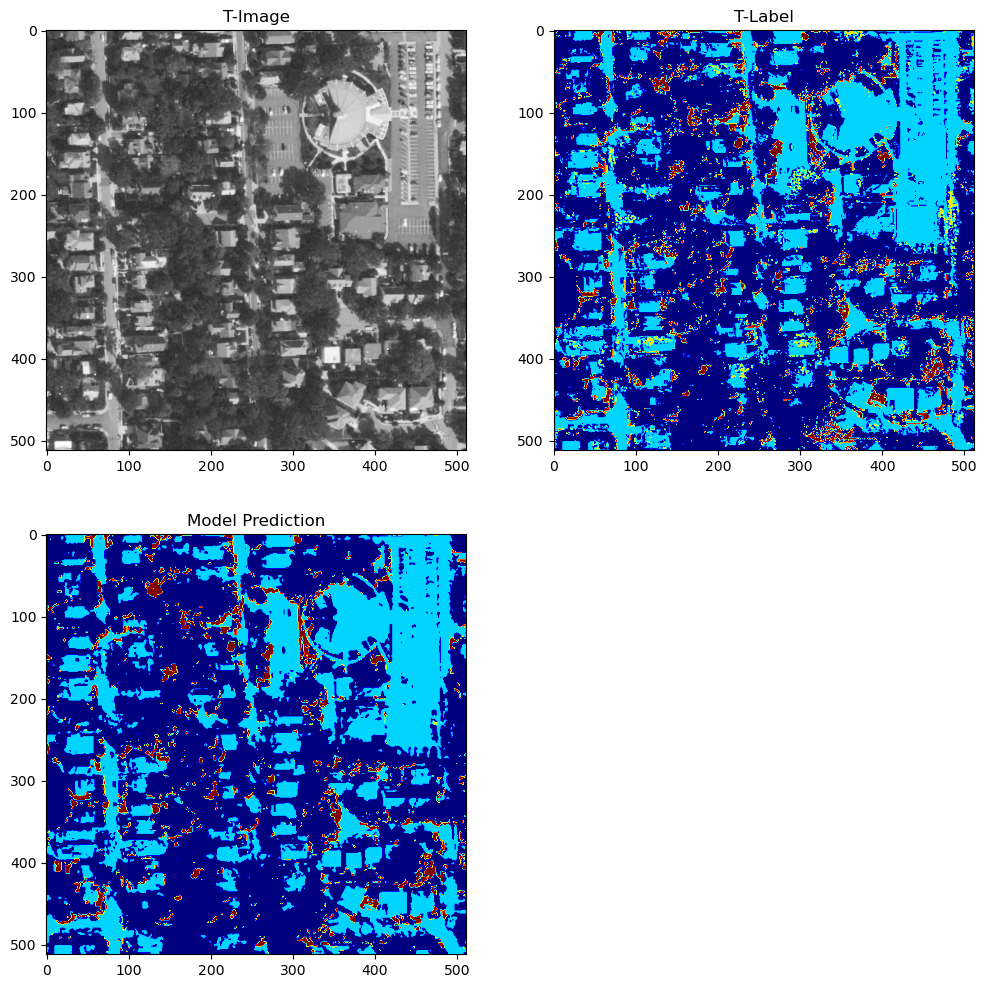

In [17]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

def evaluate_model_performance(model, X_test, y_test):
    # Generate a random test image index
    test_img_number = random.randint(0, len(X_test))
    test_img = X_test[test_img_number]
    ground_truth = y_test[test_img_number]
    test_img_input = np.expand_dims(test_img, 0)

    # Make prediction on the test image using the model
    test_pred = model.predict(test_img_input)
    test_prediction = np.argmax(test_pred, axis=3)[0,:,:]

    # Calculate Cohen's Kappa coefficient for each class
    n_classes = len(np.unique(ground_truth))
    for class_id in range(n_classes):
        y_true_class = (ground_truth == class_id).astype(int)
        y_pred_class = (test_prediction == class_id).astype(int)
        kappa = cohen_kappa_score(y_true_class.flatten(), y_pred_class.flatten())
        print(f'Cohen\'s Kappa - Class {class_id}: {kappa}')

    # Plotting the results
    plt.figure(figsize=(12, 12))
    plt.subplot(221)
    plt.title('T-Image')
    plt.imshow(test_img[:,:,0], cmap='gray')
    plt.subplot(222)
    plt.title('T-Label')
    plt.imshow(ground_truth[:,:,0], cmap='jet')
    plt.subplot(223)
    plt.title('Model Prediction')
    plt.imshow(test_prediction, cmap='jet')
    plt.show()

# Assuming you have your model `weak_supervision_model` and test data `X_test` and `y_test` already defined and trained
evaluate_model_performance(weak_supervision_model, X_test, y_test)


1/1 [==============================] - 0s 131ms/step


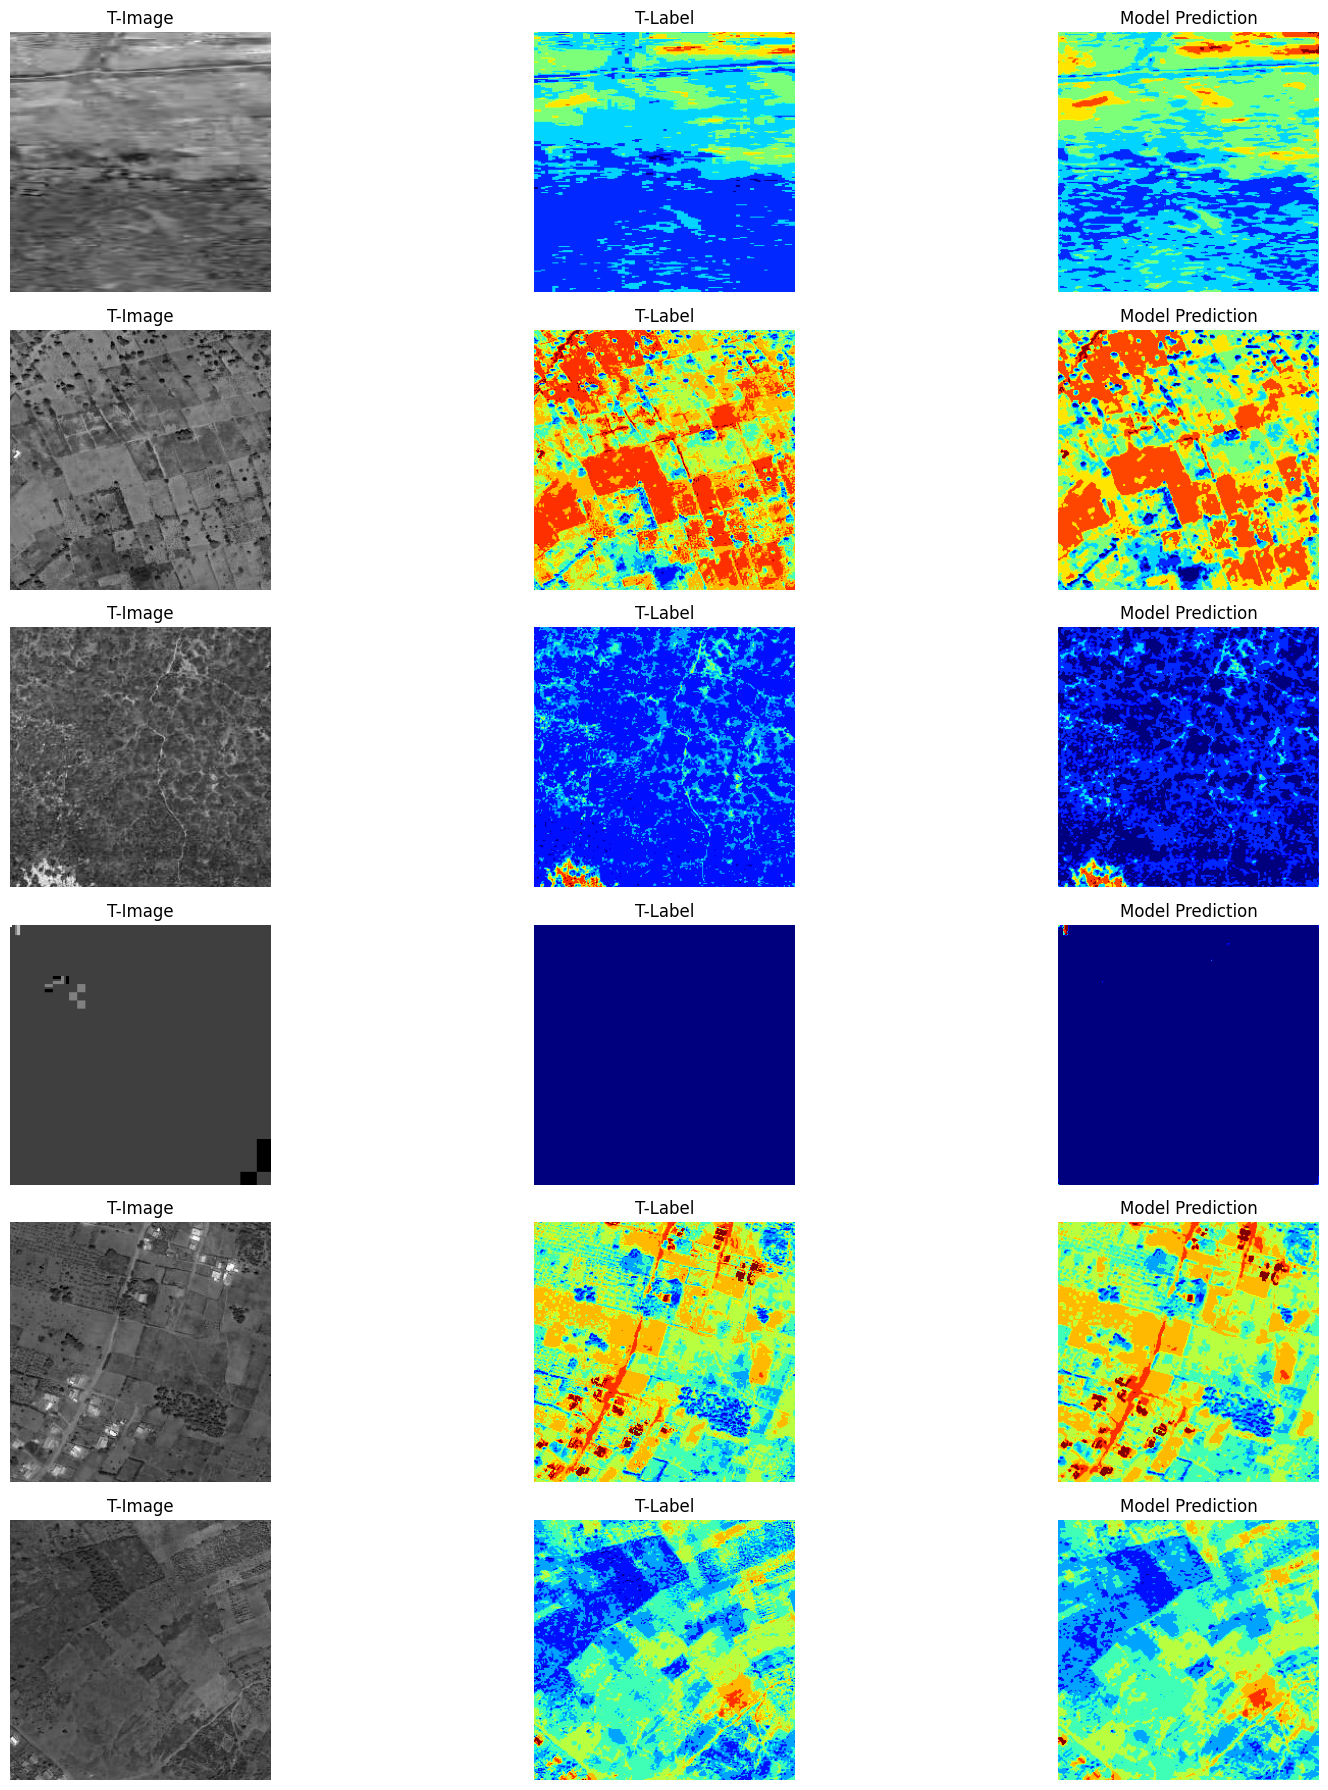

In [42]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

def evaluate_model_performance(model, X_test, y_test):
    # Initialize subplots
    plt.figure(figsize=(18, 18))

    for i in range(6):
        # Generate a random test image index
        test_img_number = random.randint(0, len(X_test) - 1)
        test_img = X_test[test_img_number]
        ground_truth = y_test[test_img_number]
        test_img_input = np.expand_dims(test_img, 0)

        # Make prediction on the test image using the model
        test_pred = model.predict(test_img_input)
        test_prediction = np.argmax(test_pred, axis=3)[0,:,:]

        # Plotting the results
        plt.subplot(6, 3, i*3 + 1)
        plt.title('T-Image')
        plt.imshow(test_img[:,:,0], cmap='gray')
        plt.axis('off')

        plt.subplot(6, 3, i*3 + 2)
        plt.title('T-Label')
        plt.imshow(ground_truth[:,:,0], cmap='jet')
        plt.axis('off')

        plt.subplot(6, 3, i*3 + 3)
        plt.title('Model Prediction')
        plt.imshow(test_prediction, cmap='jet')
        plt.axis('off')

    # Adjust layout
    plt.tight_layout()

    # Save the plot with DPI=1000
    plt.savefig('Model/c2f/predictions/pred13.tif', dpi=1000)

    # Show the plot
    plt.show()

# Assuming you have your model `weak_supervision_model` and test data `X_test` and `y_test` already defined and trained
evaluate_model_performance(weak_supervision_model, X_test, y_test)


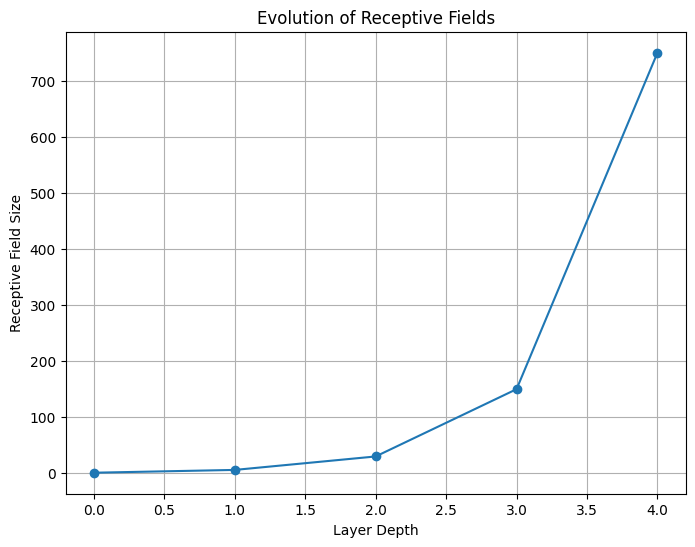

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to calculate receptive field sizes
def calculate_receptive_fields(input_size, kernel_sizes, strides):
    receptive_fields = [1]  # Start with receptive field of size 1 for the input layer
    current_size = 1
    for kernel_size, stride in zip(kernel_sizes, strides):
        current_size = current_size + (kernel_size - 1) * receptive_fields[-1]  # Calculate receptive field size
        receptive_fields.append(current_size * stride)  # Update receptive field size for next layer
    return receptive_fields

# Define model architecture parameters (kernel sizes and strides for each layer)
kernel_sizes = [3, 3, 3, 3]  # Example kernel sizes
strides = [2, 2, 2, 2]  # Example strides

# Input image size
input_size = 256

# Calculate receptive fields
receptive_fields = calculate_receptive_fields(input_size, kernel_sizes, strides)

# Visualize receptive fields
plt.figure(figsize=(8, 6))
plt.plot(receptive_fields, marker='o')
plt.title('Evolution of Receptive Fields')
plt.xlabel('Layer Depth')
plt.ylabel('Receptive Field Size')
plt.grid(True)
plt.show()

# CSV for model behavior

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the model on the test data
y_pred = weak_supervision_model.predict(X_test)
y_pred_indices = np.argmax(y_pred, axis=-1)
y_test_indices = np.argmax(y_test_cat, axis=-1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_indices.flatten(), y_pred_indices.flatten())
precision = precision_score(y_test_indices.flatten(), y_pred_indices.flatten(), average='weighted')
recall = recall_score(y_test_indices.flatten(), y_pred_indices.flatten(), average='weighted')
f1 = f1_score(y_test_indices.flatten(), y_pred_indices.flatten(), average='weighted')

# Create a DataFrame to store the evaluation metrics
metrics_df = pd.DataFrame({'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': [f1]})

# Save DataFrame to CSV file
metrics_df.to_csv('Model/c2f/CSV/model_evaluation_metrics.csv', index=False)

print("Model evaluation metrics saved successfully.")


# Prediction with class boundaries

1/1 [==============================] - 0s 173ms/step


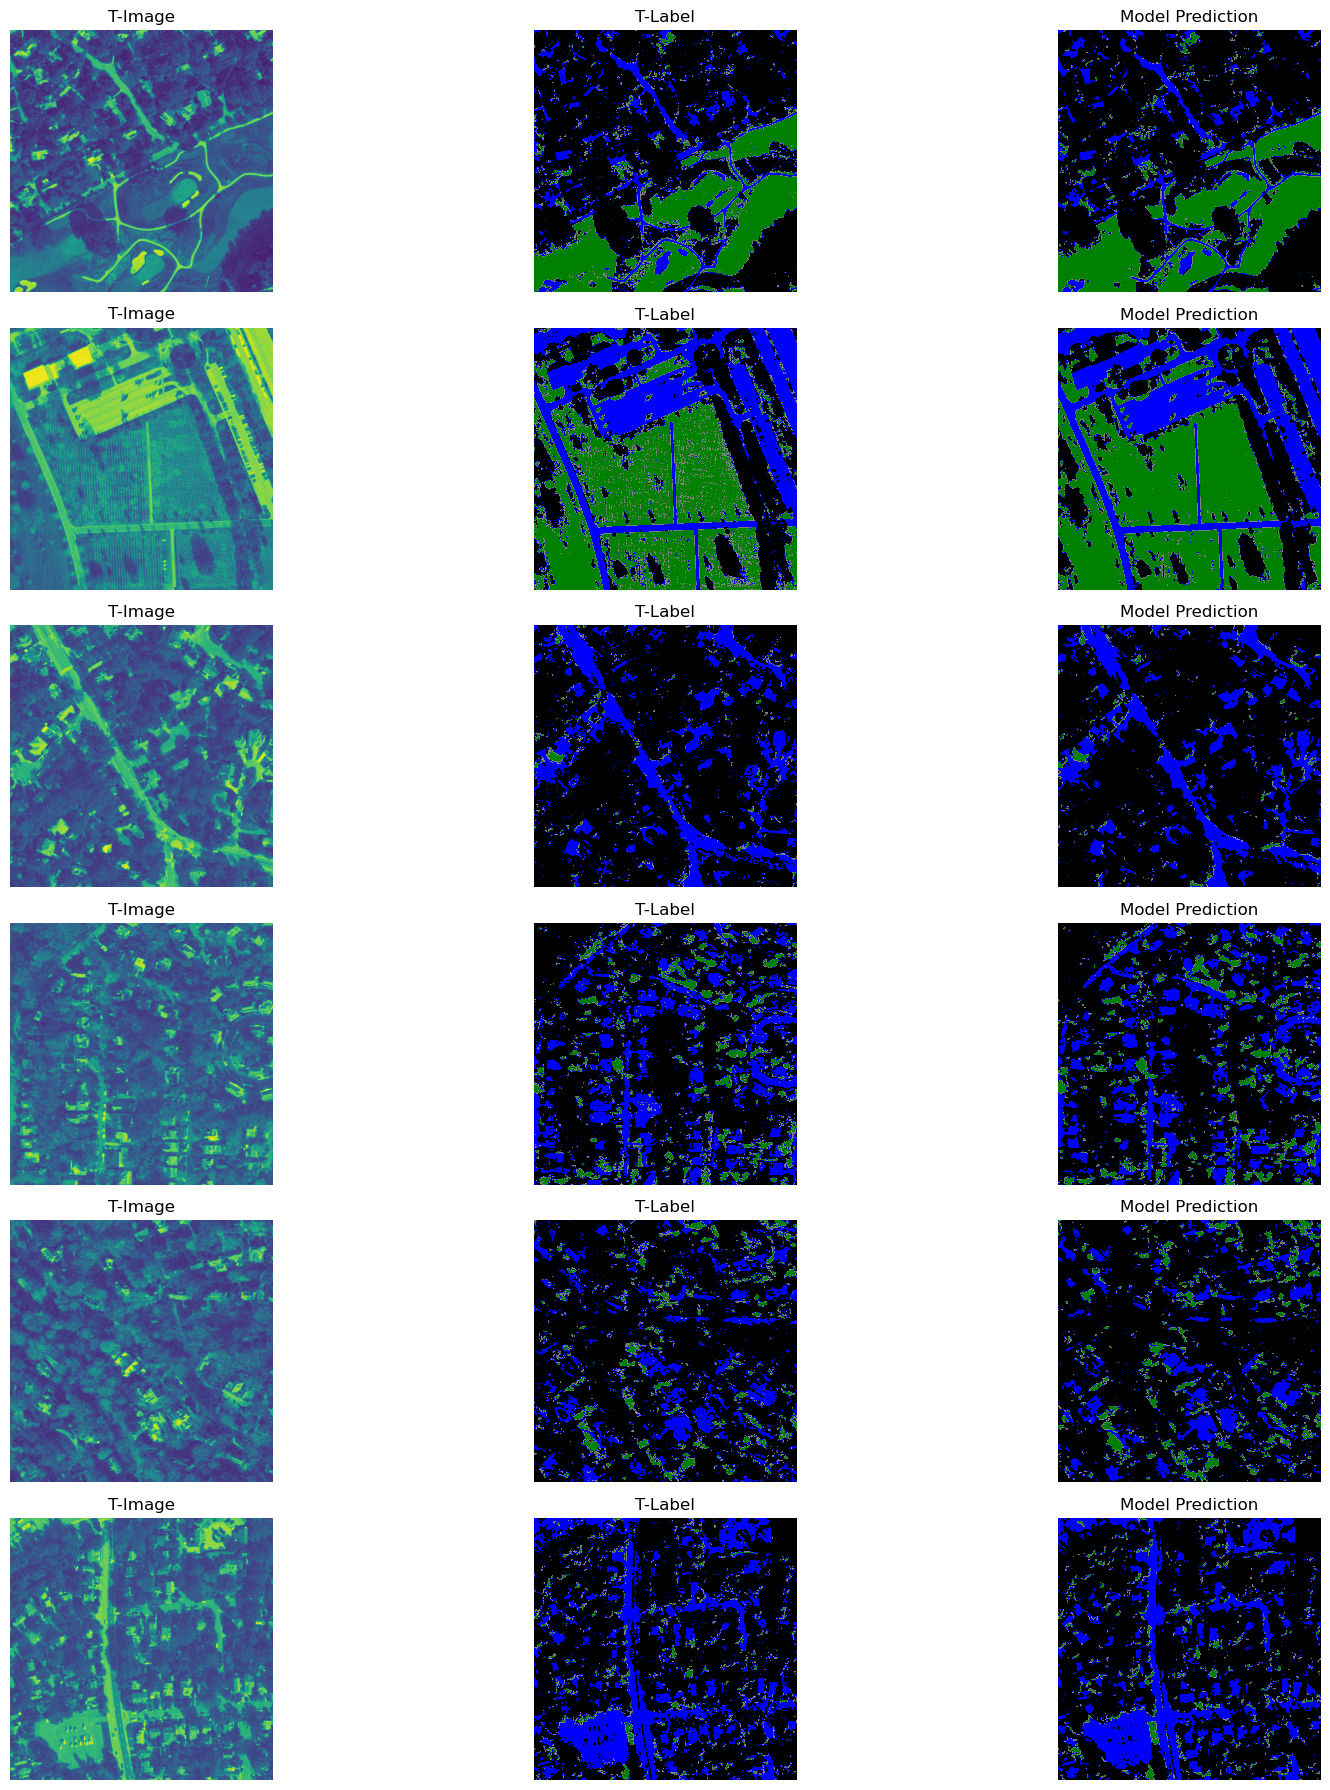

In [20]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
# from matplotlib.colors import ListedColormap

# Define colormap for real class colors
# class_colors = ['#000000', '#0000FF', '#808080', '#008000', '#FF0000', '#FFFF00', '#008080', '#00FF00']
# cmap = ListedColormap(class_colors)

def evaluate_model_performance(model, X_test, y_test):
    # Initialize subplots
    plt.figure(figsize=(18, 18))

    for i in range(6):
        # Generate a random test image index
        test_img_number = random.randint(0, len(X_test) - 1)
        test_img = X_test[test_img_number]
        ground_truth = y_test[test_img_number]
        test_img_input = np.expand_dims(test_img, 0)

        # Make prediction on the test image using the model
        test_pred = model.predict(test_img_input)
        test_prediction = np.argmax(test_pred, axis=3)[0,:,:]

        # Plotting the results
        plt.subplot(6, 3, i*3 + 1)
        plt.title('T-Image')
        plt.imshow(test_img[:,:,0])
        plt.axis('off')

        plt.subplot(6, 3, i*3 + 2)
        plt.title('T-Label')
        plt.imshow(ground_truth[:,:,0], cmap=cmap, vmin=0, vmax=len(class_colors)-1)
        plt.axis('off')

        plt.subplot(6, 3, i*3 + 3)
        plt.title('Model Prediction')
        plt.imshow(test_prediction, cmap=cmap, vmin=0, vmax=len(class_colors)-1)
        plt.axis('off')

    # Adjust layout
    plt.tight_layout()

    # Save the plot with DPI=1000
#     plt.savefig('Model/c2f/predictions/labels_predictions.png', dpi=1000)

    # Show the plot
    plt.show()

# Assuming you have your model `weak_supervision_model` and test data `X_test` and `y_test` already defined and trained
evaluate_model_performance(weak_supervision_model, X_test, y_test)


1/1 [==============================] - ETA: 0s

C:\Users\gaowutong\AppData\Local\Temp\ipykernel_13384\133557165.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.colorbar().set_ticklabels(class_labels)
C:\Users\gaowutong\AppData\Local\Temp\ipykernel_13384\133557165.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.colorbar().set_ticklabels(class_labels)


1/1 [==============================] - 0s 172ms/step


C:\Users\gaowutong\AppData\Local\Temp\ipykernel_13384\133557165.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.colorbar().set_ticklabels(class_labels)
C:\Users\gaowutong\AppData\Local\Temp\ipykernel_13384\133557165.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.colorbar().set_ticklabels(class_labels)


1/1 [==============================] - 0s 170ms/step


C:\Users\gaowutong\AppData\Local\Temp\ipykernel_13384\133557165.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.colorbar().set_ticklabels(class_labels)
C:\Users\gaowutong\AppData\Local\Temp\ipykernel_13384\133557165.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.colorbar().set_ticklabels(class_labels)


1/1 [==============================] - 0s 170ms/step


C:\Users\gaowutong\AppData\Local\Temp\ipykernel_13384\133557165.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.colorbar().set_ticklabels(class_labels)
C:\Users\gaowutong\AppData\Local\Temp\ipykernel_13384\133557165.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.colorbar().set_ticklabels(class_labels)


1/1 [==============================] - 0s 182ms/step


C:\Users\gaowutong\AppData\Local\Temp\ipykernel_13384\133557165.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.colorbar().set_ticklabels(class_labels)
C:\Users\gaowutong\AppData\Local\Temp\ipykernel_13384\133557165.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.colorbar().set_ticklabels(class_labels)


1/1 [==============================] - 0s 178ms/step


C:\Users\gaowutong\AppData\Local\Temp\ipykernel_13384\133557165.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.colorbar().set_ticklabels(class_labels)
C:\Users\gaowutong\AppData\Local\Temp\ipykernel_13384\133557165.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.colorbar().set_ticklabels(class_labels)


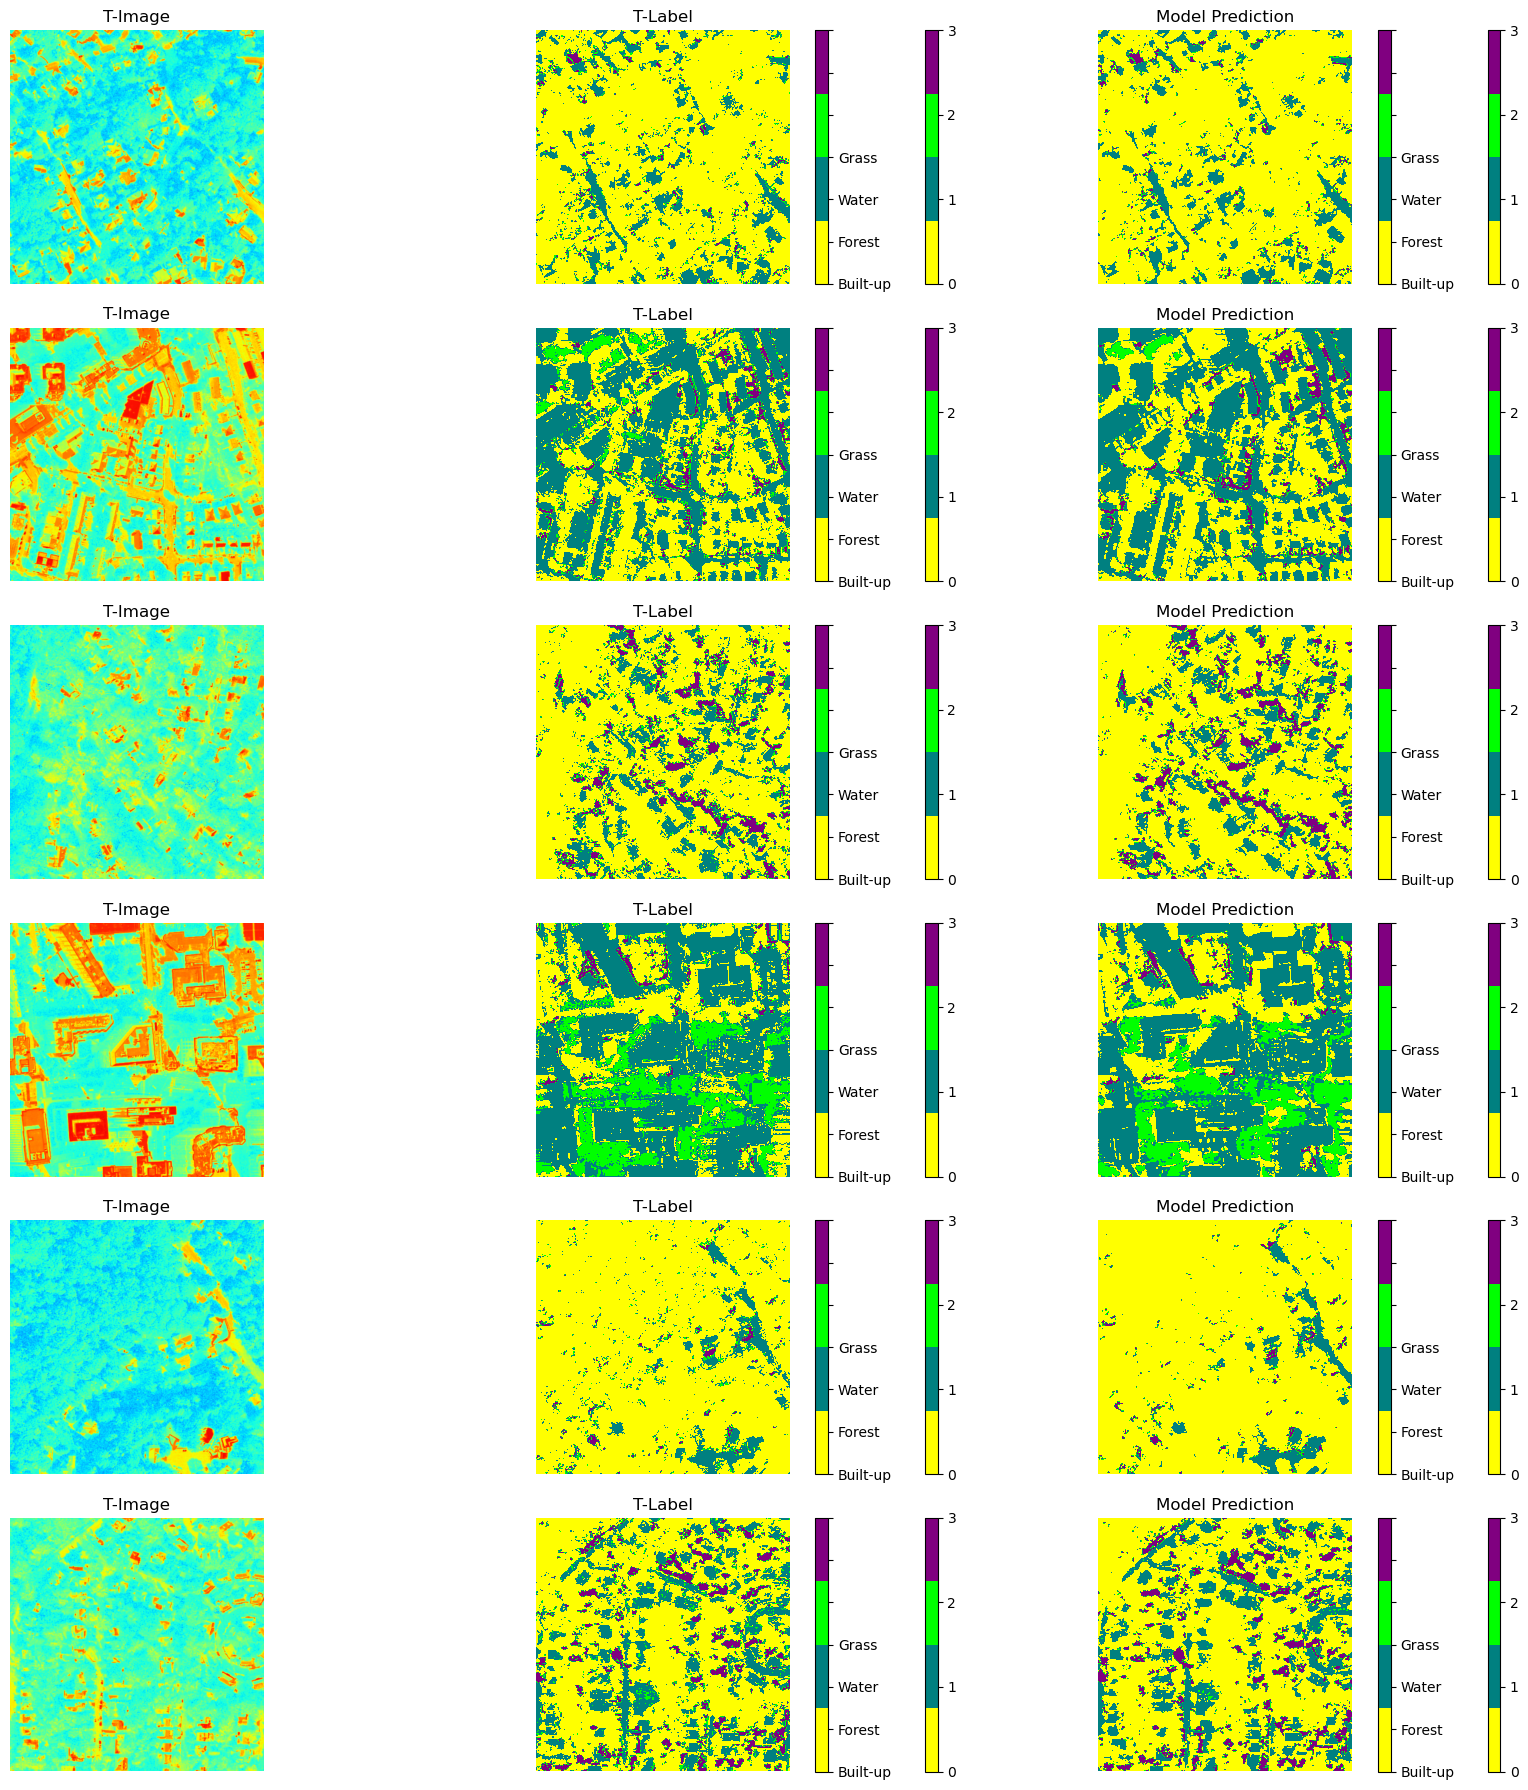

In [22]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from matplotlib.colors import ListedColormap

# Define colormap for real class colors
class_colors = [ '#FFFF00', '#008080', '#00FF00', '#800080']
class_labels = ['Built-up', 'Forest', 'Water', 'Grass', ]
cmap = ListedColormap(class_colors)

def gray_to_color(img):
    # Normalize image to range [0, 1]
    img_normalized = img.astype(float) / 255.0
    # Apply colormap (jet in this case, you can change it to any other colormap)
    img_color = plt.cm.jet(img_normalized)
    return img_color

def evaluate_model_performance(model, X_test, y_test):
    # Initialize subplots
    plt.figure(figsize=(18, 18))

    for i in range(6):
        # Generate a random test image index
        test_img_number = random.randint(0, len(X_test) - 1)
        test_img = X_test[test_img_number]
        ground_truth = y_test[test_img_number]
        test_img_input = np.expand_dims(test_img, 0)

        # Make prediction on the test image using the model
        test_pred = model.predict(test_img_input)
        test_prediction = np.argmax(test_pred, axis=3)[0,:,:]

        # Convert grayscale test image to color
        test_img_color = gray_to_color(test_img[:,:,0])

        # Plotting the results
        plt.subplot(6, 3, i*3 + 1)
        plt.title('T-Image')
        plt.imshow(test_img_color)
        plt.axis('off')

        plt.subplot(6, 3, i*3 + 2)
        plt.title('T-Label')
        plt.imshow(ground_truth[:,:,0], cmap=cmap, vmin=0, vmax=len(class_colors)-1)
        plt.colorbar(ticks=np.arange(len(class_labels)))
        plt.colorbar().set_ticklabels(class_labels)
        plt.axis('off')

        plt.subplot(6, 3, i*3 + 3)
        plt.title('Model Prediction')
        plt.imshow(test_prediction, cmap=cmap, vmin=0, vmax=len(class_colors)-1)
        plt.colorbar(ticks=np.arange(len(class_labels)))
        plt.colorbar().set_ticklabels(class_labels)
        plt.axis('off')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

# Assuming you have your model `weak_supervision_model` and test data `X_test` and `y_test` already defined and trained
evaluate_model_performance(weak_supervision_model, X_test, y_test)


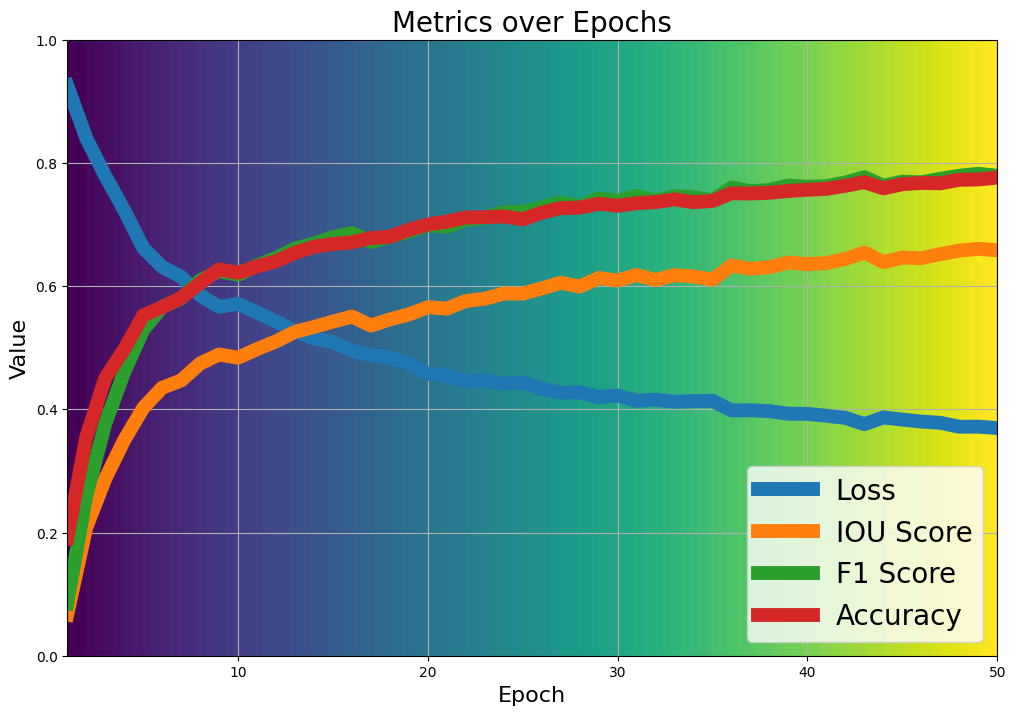

<Figure size 640x480 with 0 Axes>

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Data
epochs = list(range(1, 51))
loss = [0.9255, 0.8403, 0.7791, 0.7233, 0.662, 0.6312, 0.6152, 0.5851, 0.5663, 0.5713,
        0.5573, 0.5426, 0.5273, 0.5151, 0.5093, 0.4952, 0.4879, 0.4839, 0.4749, 0.4576,
        0.455, 0.4457, 0.4468, 0.4418, 0.4437, 0.4337, 0.4267, 0.4279, 0.4197, 0.4225,
        0.4137, 0.4157, 0.4122, 0.4134, 0.4138, 0.3982, 0.3985, 0.397, 0.3928, 0.3926,
        0.3895, 0.3861, 0.3759, 0.3869, 0.3833, 0.3801, 0.3781, 0.3717, 0.3719, 0.3696]
iou_score = [0.0671, 0.208, 0.2872, 0.3501, 0.4022, 0.435, 0.4468, 0.4743, 0.4891, 0.4837,
             0.4978, 0.5103, 0.5258, 0.5337, 0.5424, 0.5505, 0.536, 0.546, 0.554, 0.5658,
             0.5634, 0.5759, 0.5795, 0.5879, 0.5878, 0.5963, 0.6054, 0.5993, 0.6132, 0.609,
             0.618, 0.6099, 0.6179, 0.6156, 0.6105, 0.6336, 0.6281, 0.6307, 0.6383, 0.6358,
             0.6374, 0.6441, 0.6545, 0.6388, 0.6463, 0.6453, 0.652, 0.6575, 0.6605, 0.6583]
f1_score = [0.0851, 0.2592, 0.3765, 0.4604, 0.5286, 0.5664, 0.5801, 0.6093, 0.6245, 0.6183,
            0.6332, 0.6457, 0.6609, 0.6689, 0.6795, 0.6862, 0.6716, 0.6802, 0.6882, 0.6992,
            0.6962, 0.7076, 0.711, 0.72, 0.7203, 0.7277, 0.7357, 0.7293, 0.7424, 0.7385,
            0.7464, 0.7387, 0.746, 0.7444, 0.7394, 0.76, 0.7542, 0.7561, 0.7633, 0.7612,
            0.7623, 0.7682, 0.7768, 0.763, 0.7696, 0.7685, 0.7743, 0.7792, 0.7824, 0.7791]
accuracy = [0.1906, 0.3546, 0.4508, 0.4973, 0.5525, 0.5658, 0.581, 0.6049, 0.6274, 0.6216,
            0.6319, 0.6403, 0.6541, 0.6639, 0.6684, 0.6711, 0.678, 0.6803, 0.6913, 0.7001,
            0.7046, 0.7114, 0.712, 0.7131, 0.7085, 0.7193, 0.7266, 0.7275, 0.7337, 0.7304,
            0.7346, 0.7364, 0.7408, 0.7362, 0.7383, 0.7508, 0.7503, 0.7516, 0.7545, 0.7564,
            0.7579, 0.7629, 0.7688, 0.7587, 0.7655, 0.7674, 0.7669, 0.7726, 0.7732, 0.7762]

# Plotting with gradient background
fig, ax = plt.subplots(figsize=(12, 8))

gradient = np.linspace(0, 1, 100).reshape(1, -1)
ax.imshow(gradient, aspect='auto', cmap='viridis', extent=(epochs[0], epochs[-1], 0, 1))

# Increase line width
lw = 10

ax.plot(epochs, loss, label='Loss', linestyle='-', linewidth=lw)
ax.plot(epochs, iou_score, label='IOU Score', linestyle='-', linewidth=lw)
ax.plot(epochs, f1_score, label='F1 Score', linestyle='-', linewidth=lw)
ax.plot(epochs, accuracy, label='Accuracy', linestyle='-', linewidth=lw)

ax.set_title('Metrics over Epochs', fontsize=20)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Value', fontsize=16)
ax.legend(fontsize=20)
ax.grid(True)

plt.show()
# Save the graph with DPI=1000
plt.savefig('model training behavior/Training_metrics222.png', dpi=600)
plt.show()



# C2FNetwork Validation Bugesera

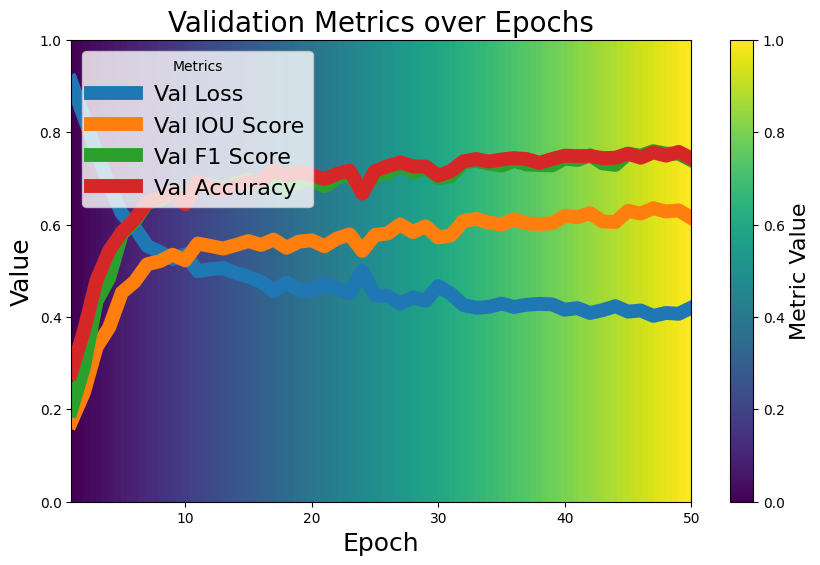

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Data
epochs = list(range(1, 51))
val_loss = [0.9089, 0.8326, 0.7568, 0.6861, 0.6232, 0.595, 0.5536, 0.5407, 0.5254, 0.5355,
            0.4989, 0.5034, 0.5056, 0.4952, 0.4872, 0.4763, 0.4561, 0.4744, 0.4585, 0.4581,
            0.4712, 0.462, 0.4509, 0.4992, 0.4475, 0.4448, 0.4293, 0.4423, 0.4348, 0.4666,
            0.4501, 0.4257, 0.4198, 0.4218, 0.4288, 0.4216, 0.4263, 0.4283, 0.4272, 0.4155,
            0.4191, 0.4085, 0.4147, 0.4233, 0.4114, 0.414, 0.4023, 0.4086, 0.4068, 0.42]
val_iou_score = [0.1737, 0.2362, 0.3347, 0.3777, 0.4528, 0.476, 0.5141, 0.5205, 0.5346, 0.5224,
                 0.5589, 0.5536, 0.548, 0.5557, 0.5642, 0.5558, 0.5674, 0.5496, 0.5631, 0.5658,
                 0.5529, 0.5697, 0.5785, 0.5431, 0.5773, 0.5808, 0.6002, 0.5834, 0.5962, 0.572,
                 0.5765, 0.608, 0.6122, 0.604, 0.6, 0.6114, 0.6025, 0.6009, 0.6028, 0.6182,
                 0.6157, 0.6246, 0.6064, 0.6054, 0.6296, 0.6236, 0.6354, 0.6281, 0.6307, 0.6141]
val_f1_score = [0.1988, 0.2911, 0.4337, 0.4846, 0.58, 0.6063, 0.6476, 0.6533, 0.6676, 0.6549,
                0.6906, 0.6847, 0.6798, 0.6891, 0.6968, 0.6883, 0.6971, 0.6786, 0.6926, 0.6974,
                0.6826, 0.7008, 0.7075, 0.6703, 0.7066, 0.7102, 0.7289, 0.7123, 0.7229, 0.7002,
                0.7044, 0.7346, 0.7381, 0.7315, 0.7272, 0.7379, 0.7298, 0.7287, 0.728, 0.7427,
                0.7396, 0.7498, 0.7322, 0.7291, 0.7533, 0.7491, 0.7588, 0.7533, 0.7534, 0.7394]
val_accuracy = [0.2797, 0.3701, 0.4799, 0.544, 0.5835, 0.611, 0.6486, 0.6586, 0.67, 0.6439,
                0.6931, 0.6792, 0.6742, 0.6842, 0.692, 0.6943, 0.7174, 0.706, 0.714, 0.7074,
                0.6983, 0.7097, 0.7168, 0.6668, 0.7159, 0.7263, 0.7347, 0.7259, 0.7254, 0.7057,
                0.7158, 0.7368, 0.7418, 0.7362, 0.7408, 0.7438, 0.7417, 0.7335, 0.7418, 0.7491,
                0.7481, 0.7485, 0.7437, 0.7445, 0.7535, 0.7445, 0.7562, 0.7491, 0.7573, 0.743]

# Plotting with gradient background
fig, ax = plt.subplots(figsize=(10, 6))

gradient = np.linspace(0, 1, 100).reshape(1, -1)
ax.imshow(gradient, aspect='auto', cmap='viridis', extent=(epochs[0], epochs[-1], 0, 1))

# Increase line width
lw = 10

ax.plot(epochs, val_loss, label='Val Loss', linestyle='-', linewidth=lw)
ax.plot(epochs, val_iou_score, label='Val IOU Score', linestyle='-', linewidth=lw)
ax.plot(epochs, val_f1_score, label='Val F1 Score', linestyle='-', linewidth=lw)
ax.plot(epochs, val_accuracy, label='Val Accuracy', linestyle='-', linewidth=lw)

ax.set_title('Validation Metrics over Epochs', fontsize=20)
ax.set_xlabel('Epoch', fontsize=18)
ax.set_ylabel('Value', fontsize=18)

# Create color bar for legend
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=ax)
cbar.set_label('Metric Value', fontsize=16)

# # Show legend like heatmap
ax.legend(loc='upper left', title='Metrics', fontsize=16)

# Save the graph with DPI=1000
plt.savefig('model training behavior/validation_metrics222.png', dpi=600)
plt.show()
